## Import libraries

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
import pickle

## Augment the data
Since the number of samples is similar in both car and non-car sets, I suspect that the classifier could prefer the car class, because in real apllication I presume much more likely presence of noncar class than car class. I will try to resolve this with data augmentation.

On top of that, I will blur the images to supress the noise that seemed to cause problems in previous attempt.

In [31]:
# # Start with car class
# for image in glob.glob('vehicles/*/*.png'):
#     # blur and save augmented images
#     path = image.replace('vehicles', 'vehicles_augmented\\blurred')
#     image = mpimg.imread(image)
#     image = cv2.GaussianBlur(image, (5, 5), 0)
#     mpimg.imsave(path, image)

# # Then the noncar class
# for image in glob.glob('non-vehicles/*/*.png'):
#     # first blur image and save
#     orig_path = image
#     image = mpimg.imread(image)
#     image = cv2.GaussianBlur(image, (5, 5), 0)
#     path = orig_path.replace('non-vehicles', 'non-vehicles_augmented\\blurred')
#     mpimg.imsave(path, image)
#     # then rotate 90, 180, 270 degrees and save
#     path = orig_path.replace('non-vehicles', 'non-vehicles_augmented\\rotate90')
#     mpimg.imsave(path, cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[0]//2, image.shape[1]//2), 90, 1), (image.shape[0], image.shape[1])))
#     path = orig_path.replace('non-vehicles', 'non-vehicles_augmented\\rotate180')
#     mpimg.imsave(path, cv2.warpAffine(image, 
#                                       cv2.getRotationMatrix2D((image.shape[0]//2, image.shape[1]//2), 180, 1), 
#                                       (image.shape[0], image.shape[1])))
#     path = orig_path.replace('non-vehicles', 'non-vehicles_augmented\\rotate270')
#     mpimg.imsave(path, cv2.warpAffine(image, 
#                                       cv2.getRotationMatrix2D((image.shape[0]//2, image.shape[1]//2), 270, 1), 
#                                       (image.shape[0], image.shape[1])))

## Load the data and explore it

Read in the augmented data sets and display number of samples in each one.

In [32]:
## Read in vehicle and non-vehicle data
# Count samples in augmented sets
cars = []
for image in glob.glob('vehicles_augmented/**/**/*.png'):
    cars.append(image)

notcars = []
for image in glob.glob('non-vehicles_augmented/**/**/*.png'):
    notcars.append(image)
    
print('Number of car images: %d' % len(cars))
print('Number of non car images: %d' % len(notcars))

Number of car images: 8792
Number of non car images: 35872


Show 10 random pictures from car set.

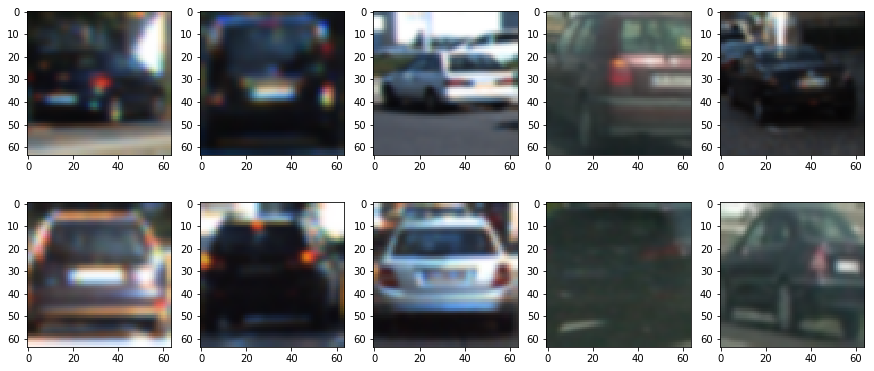

In [33]:
plt.figure(figsize=(15,10))
n = 10
columns = 5
for i in range(n):
    plt.subplot(n / columns + 1, columns, i + 1)
    plt.imshow(mpimg.imread(cars[np.random.randint(len(cars))]), interpolation='none')
plt.show()

Show 10 random pictures from non-car set.

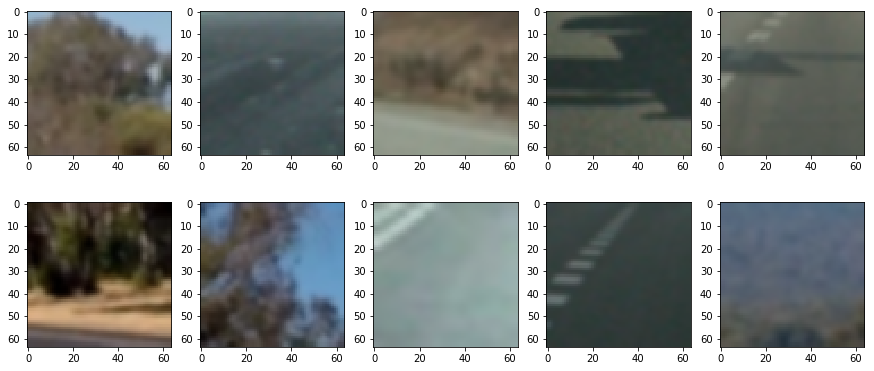

In [34]:
plt.figure(figsize=(15,10))
n = 10
columns = 5
for i in range(n):
    plt.subplot(n / columns + 1, columns, i + 1)
    plt.imshow(mpimg.imread(notcars[np.random.randint(len(cars))]), interpolation='none')
plt.show()

## HOG feature extraction

### Function for HOG feature extraction

Reuse the function from the lessons.

In [35]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, 
                                  feature_vector=feature_vec,
                                  block_norm='L1')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, 
                       feature_vector=feature_vec,
                       block_norm='L1')
        return features

### Define function for batch feature extraction from list of images

Reuse the function from the lessons.

In [36]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        try:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)      

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        except:
            pass
    # Return list of feature vectors
    return features

## HOG parameters

In [37]:
### Final selected parameters
colorspace = 'YUV'
orient = 15
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
param_name = colorspace+'_'+str(orient)+'_'+str(pix_per_cell)+'_'+str(cell_per_block)+'_'+str(hog_channel)
print('Single channel feature vector length: %d' %len(get_hog_features(mpimg.imread(cars[np.random.randint(len(cars))])[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)))

Single channel feature vector length: 540


C:\Users\Ulicny\Anaconda3\envs\py35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Train the classifier

In [38]:
# t=time.time()
# # Extract the HOG features
# car_features = extract_features(cars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to extract HOG features...')
# # Create an array stack of feature vectors
# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# from sklearn.metrics import precision_score
# precision = precision_score(svc.predict(X_test), y_test)
# print('Precision of SVC = ', round(precision, 4))
# 
# # Save the classifier
# with open('classifier_%s.p' %param_name, 'wb') as handle:
#     pickle.dump(svc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# from sklearn.metrics import roc_curve, auc
# y_score = svc.decision_function(X_test)
# # Compute ROC curve and ROC area for each class
# fpr, tpr, thresholds = roc_curve(y_test[:], y_score[:])
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(12,8))
# lw = 2

# plt.xscale('log')
# plt.plot(fpr, tpr, color='blue',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")

# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
# ax2.set_ylabel('Threshold',color='r')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])


# ax2.set_ylim([-3,5])
# ax2.set_xlim([fpr[0],0.04])
# plt.show()

In [40]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = svc
# ylim=(0.7, 1.01)
# n_jobs=4
# train_sizes=np.linspace(.1, 1.0, 5)

# plt.figure(figsize=(12,8))
# plt.title('Learning curve SVM')
# if ylim is not None:
#     plt.ylim(*ylim)
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.legend(loc="best")
# plt.show()

In [41]:
# load the classifier
with open('classifier_%s.p' %param_name, 'rb') as handle:
    print(handle)
    svc = pickle.load(handle)

<_io.BufferedReader name='classifier_YUV_15_16_2_ALL.p'>


### Demonstrate HOG feature extraction on random image

C:\Users\Ulicny\Anaconda3\envs\py35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


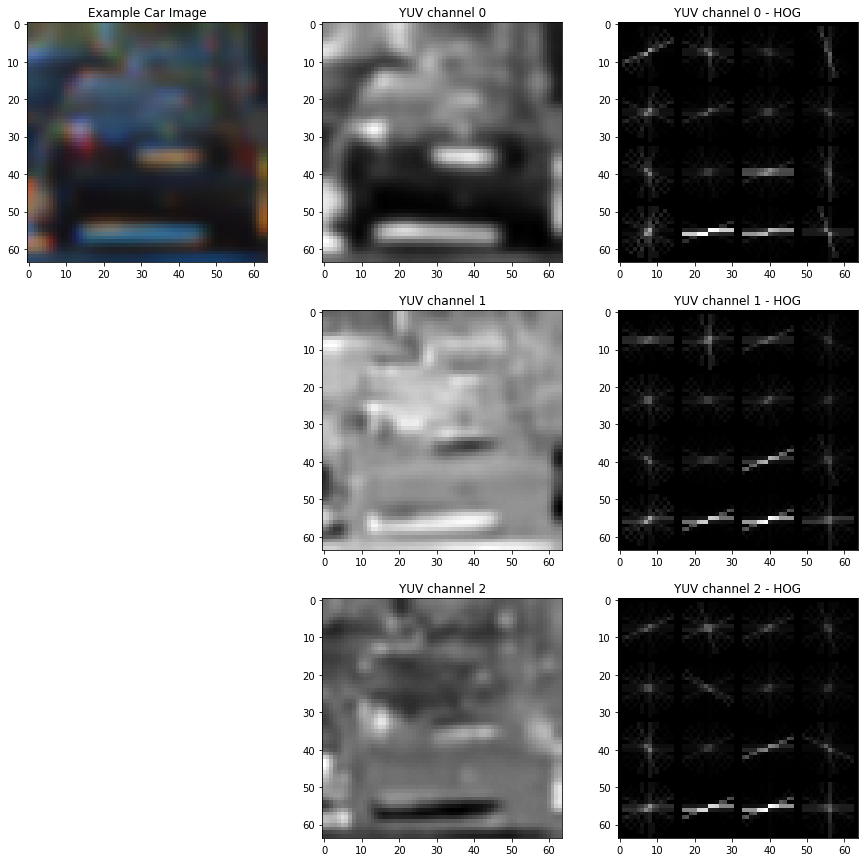

In [42]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
color_transformed = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
# Call our function with vis=True to see an image output
_, hog_image0 = get_hog_features(color_transformed[:,:,0], orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)
_, hog_image1 = get_hog_features(color_transformed[:,:,1], orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)
_, hog_image2 = get_hog_features(color_transformed[:,:,2], orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(15,15))
plt.subplot(331)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(332)
plt.imshow(color_transformed[:,:,0], cmap='gray')
plt.title('YUV channel 0')
plt.subplot(333)
plt.imshow(hog_image0, cmap='gray')
plt.title('YUV channel 0 - HOG')


plt.subplot(335)
plt.imshow(color_transformed[:,:,1], cmap='gray')
plt.title('YUV channel 1')
plt.subplot(336)
plt.imshow(hog_image1, cmap='gray')
plt.title('YUV channel 1 - HOG')

plt.subplot(338)
plt.imshow(color_transformed[:,:,2], cmap='gray')
plt.title('YUV channel 2')
plt.subplot(339)
plt.imshow(hog_image2, cmap='gray')
plt.title('YUV channel 2 - HOG')
plt.show()

## Sliding window approach

In [43]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [44]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, color_space, orient, pix_per_cell, cell_per_block, hog_channel):
    draw_img = np.copy(img)
    
    # Scale the image to 0-1
    if np.amax(img)>2:
        img = img.astype(np.float32)/255

   
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    if hog_channel == 'ALL':   
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 1  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bboxes = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Make a prediction
                test_prediction = svc.predict(hog_features)


                #if test_prediction == 1:
                if svc.decision_function(hog_features)>0:
                    #print(test_prediction, svc.decision_function(hog_features))
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    else:
        ch = ctrans_tosearch[:,:,hog_channel]
        
        # Define blocks and steps as above
        nxblocks = (ch.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 1  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bboxes = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel().reshape(1, -1) 

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                if svc.predict(hog_features) == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes

In [45]:
def add_heat(heatmap, bbox_list, weight=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += weight*1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, boxes=None):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        if boxes:
            boxes.extend([bbox for i in range(2)])
    # Return the image
    return img

In [51]:
# Class to store bboxes from previous frames
class Boxes():
    def __init__(self):
        # history of rectangles - previous 10 frames
        self.boxes = [[] for i in range(10)] 
        
    def add_boxes(self, new_boxes):
        # add boxes from the new frame, delete boxes from the oldest one
        self.boxes.append(new_boxes)
        self.boxes.pop(0)
            
def detect_cars(img):
    orig = np.copy(img)
    # rescale the image to 0-1
    if np.amax(img)>200:
        img = img.astype(np.float32)/255
        
    # Go through different scales and collect detected vehicles into bboxes list
    bboxes = []
 
    ystart = 400
    ystop = 500
    scale = 1
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 390
    ystop = 510
    scale = 1.5
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 400
    ystop = 520
    scale = 1.5
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 380
    ystop = 572
    scale = 2
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 400
    ystop = 560
    scale = 2.5
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 420
    ystop = 580
    scale = 2.5
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
    ystart = 458
    ystop = 650
    scale = 3
    _, bb = find_cars(img, ystart, ystop, scale, svc, colorspace, orient, pix_per_cell, cell_per_block, hog_channel)
    bboxes.append(bb)
    
   
        
    # flatten the list
    bboxes = [item for sublist in bboxes for item in sublist] 
    # add it to history of frames
    boxes.add_boxes(bboxes)
    
    # initialize heat map
    heatmap_img = np.zeros_like(img[:,:,0])
    
#     define weights to disadvantage older frames in the heatmap
#     exp = np.exp((np.arange(10))/5)
#     weights = exp/np.amax(exp)

#     for bb, weight in zip(boxes.boxes, weights):
#         heatmap_img = add_heat(heatmap_img, bb)
        
    for bb in boxes.boxes:
        heatmap_img = add_heat(heatmap_img, bb)
     
    # apply threshold to the heatmap
    thresholded_img = np.copy(heatmap_img)
    threshold = 5
    thresholded_img = apply_threshold(thresholded_img, threshold)
    
    # draw the confident vehicle detection
    from scipy.ndimage.measurements import label
    labels = label(thresholded_img)
    draw_img = draw_labeled_bboxes(np.copy(orig), labels)
    
    # flag for diagnostic output
    diag = 0
    if diag:
        # Diagnostic output video contains raw detected boxes, heatmap, threshold and resulting bounding boxes
        detected_img = draw_boxes(orig, bboxes, color=(0, 0, 255), thick=3)
        draw_labeled_bboxes(detected_img, labels)
        heatmap = np.copy(heatmap_img)
        heatmap_img = 255*(1-np.exp(-heatmap_img/5))
        heatmap_img = cv2.cvtColor(heatmap_img.astype('uint8'), cv2.COLOR_GRAY2RGB) 
        cv2.putText(heatmap_img, 'History', (100, 50), 0, 1, (0, 255, 0), 2, 20)
        cv2.putText(heatmap_img, 'Heatmap maximum: %3.0d' %np.amax(heatmap), (500, 50), 0, 1, (0, 255, 0), 2, 20)
        cv2.putText(heatmap_img, 'Threshold: %3.0d' %threshold, (1000, 50), 0, 1, (0, 255, 0), 2, 20)
        for i in range(10):
            try:
                cv2.putText(heatmap_img, '%2.0d: %2.0d' %(10-i, len(boxes.boxes[i])), (100, 600-50*(i+1)), 0, 1, (0, 255, 0), 2, 20)
            except:
                cv2.putText(heatmap_img, '%2.0d: %2.0d' %(10-i, 0), (100, 600-50*(i+1)), 0, 1, (0, 255, 0), 2, 20)
        
        diag_img = np.concatenate((cv2.resize(draw_img, (0,0), fx=0.5, fy=0.5), cv2.resize(heatmap_img, (0,0), fx=0.5, fy=0.5) ), axis=0)
        draw_img = np.concatenate((detected_img, diag_img), axis=1)
        return draw_img
    else:
        return draw_img

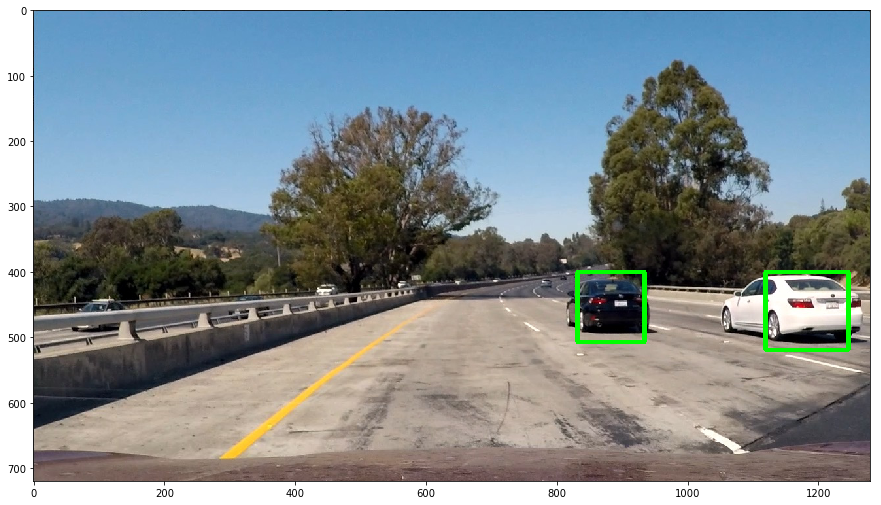

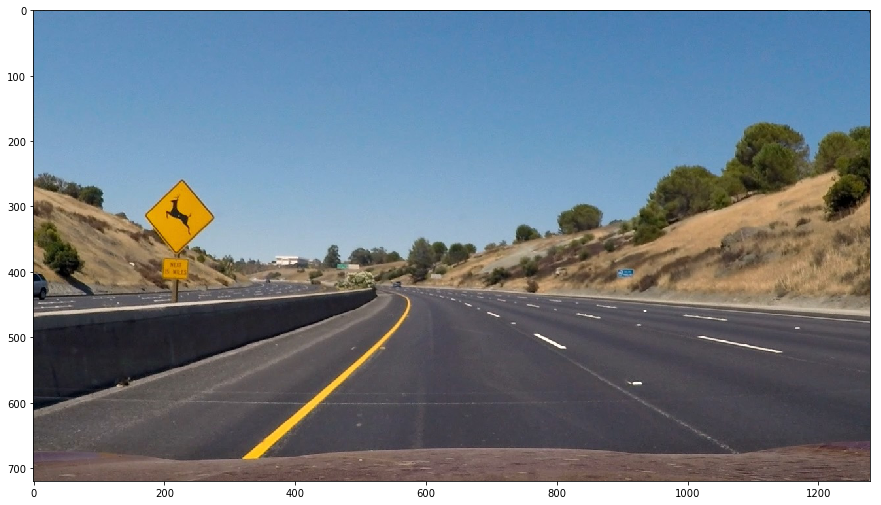

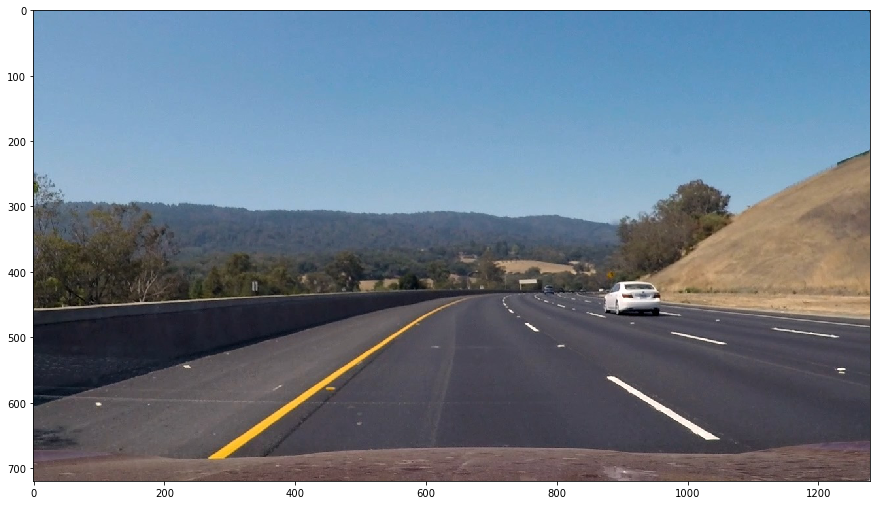

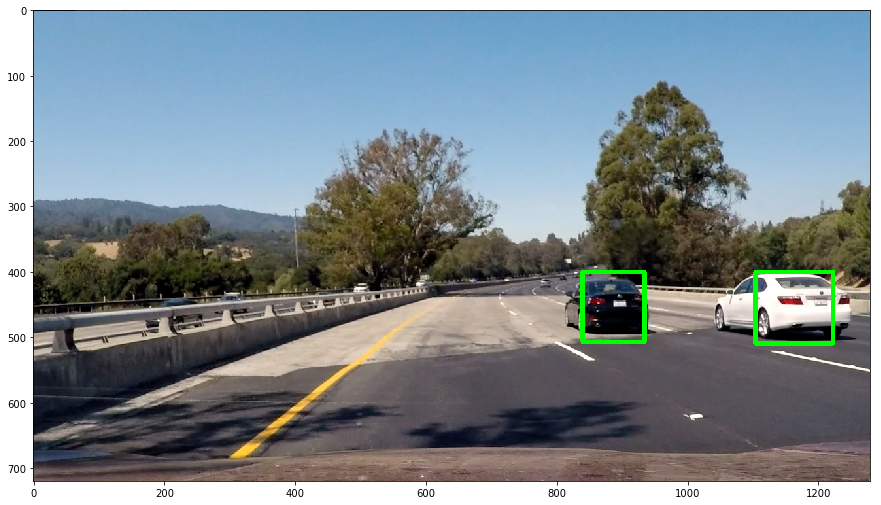

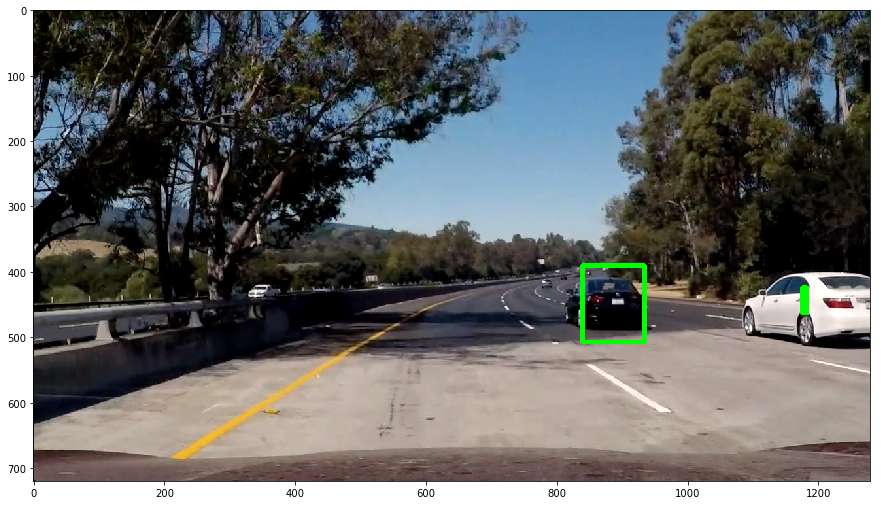

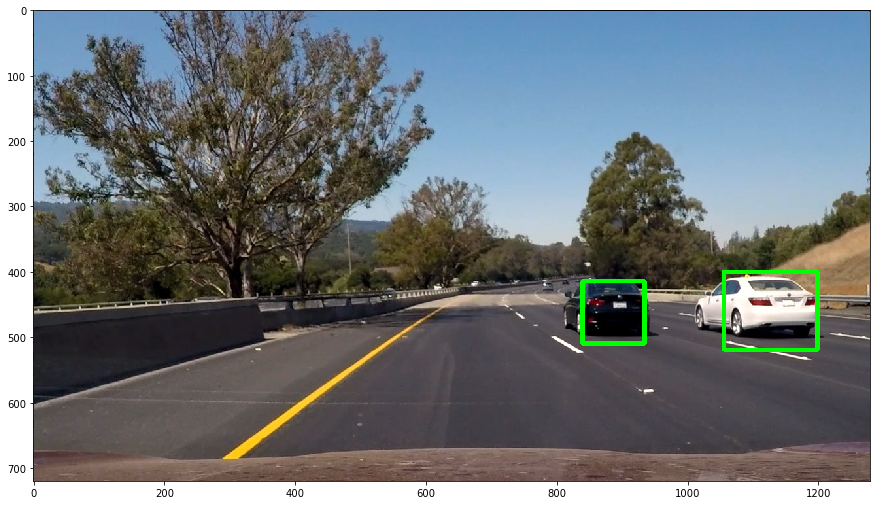

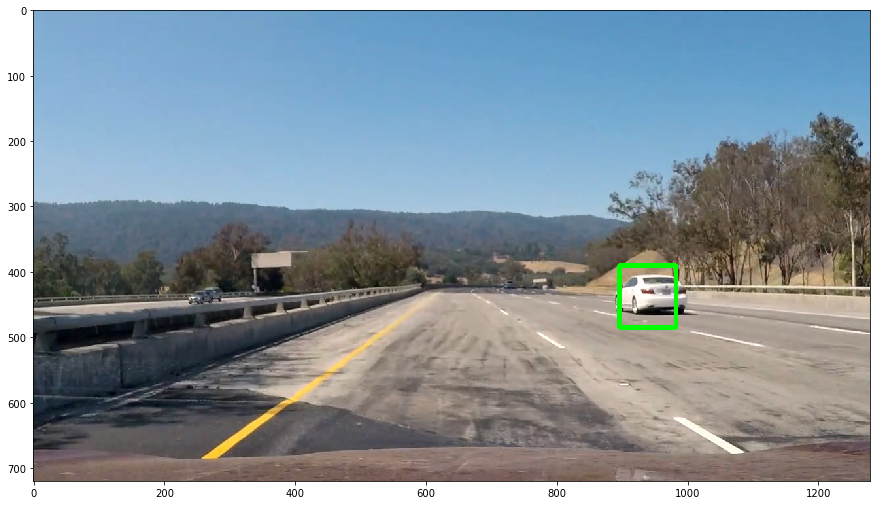

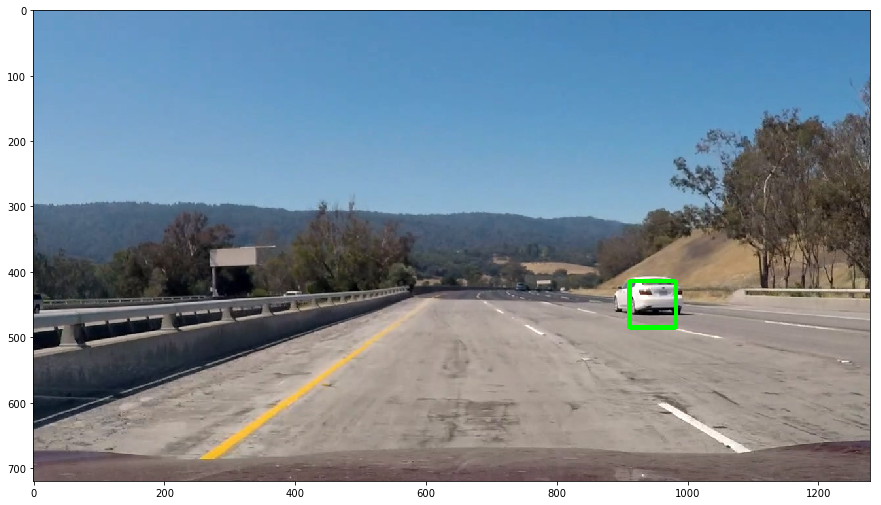

In [52]:
# Test the pipeline on all test images
for image in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image)
    plt.figure(figsize=(15,10))
    boxes = Boxes()
    t=time.time()
    out_img = detect_cars(image)
    plt.imshow(out_img)
    plt.show()
    time.sleep(0.1)

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
# Detect cars in video
boxes = Boxes()
white_output = 'project_video_output_augmented_thres5_no-weights_%s.mp4' %param_name
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output_augmented_thres5_no-weights_YUV_15_16_2_ALL.mp4
[MoviePy] Writing video project_video_output_augmented_thres5_no-weights_YUV_15_16_2_ALL.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:13<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_augmented_thres5_no-weights_YUV_15_16_2_ALL.mp4 

Wall time: 11min 15s
